# Identifying Negative Sentiment in Tweets

## Business Problem

Google is seeking to increase Android's share of the U.S. smartphone and tablet markets.  To do so, they are seeking information on what consumers don't like about their devices.  By focusing on pain points, they hope to engineer improvements that will attract and retain more customers.

While negative sentiment toward products is available in form of survey responses and customer complaints, Google also hopes to access the opinions conveyed in social media posts.  To do so, they need to identify posts which express concerns and frustrations about mobile devices from among thousands of other posts.  Google is frustrated that their analysts spend so much time reading through positive and neutral posts to find the negative ones, which comprise just 6% of all posts.

My task is to build a natural language processing model which can identify the negative tweets.  They have asked that the model focus on catching as many negative tweets as possible, but would like analysts to be able to work at least twice as fast.  So, the model should eliminate enough positive and neutral posts that negative tweets comprise at least 12% of all the tweets returned, and hopefully more.

## Data Understanding

To identify posts with gripes, I analyzed over 9,000 tweets from a dataset provided by Crowdflower via [data.world](https://data.world/crowdflower/brands-and-product-emotions).  The tweets all contain references to Google or Apple products, and relate to the SXSW (South by Southwest) Conference in 2011.  Although the data are a decade old, and the products discussed seem ancient (e.g. iPad 2), the words used to convey negative emotions have not changed.  

Each tweet in the dataset has been rated by humans as showing a positive emotion, negative emotion, or no emotion toward the Google or Apple product mentioned.  59% of tweets were tagged as postive and 6% as negative, making negative tweets the smallest category by far.  I combined the positive and no-emotion categories in order to build a binary classification model that can identify negative tweets negative tweets.

## Data Preparation

In [23]:
# import libraries

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from gensim.models import Word2Vec

import utils as ut

In [2]:
# import data

data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')


In [3]:
data.head(100)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion


In [4]:
len(data)

9093

In [5]:
# shorten column names

data.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product': 'label'}, inplace=True)

In [6]:
# drop this column since this model will only predict sentiment, not the product as well

data.drop(columns = 'emotion_in_tweet_is_directed_at', inplace=True)

In [7]:
# data has one null value in the text

data.isna().sum()

text     1
label    0
dtype: int64

In [8]:
# drop null value

data.dropna(inplace=True)

In [9]:
len(data)

9092

In [10]:
data.head(10)

# now index is missing #6

,text,label
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Positive emotion
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,Positive emotion
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Positive emotion


In [11]:
# reset index so train/test splits work later on

data.reset_index(drop=True, inplace=True)

In [12]:
data.head(10)

,text,label
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Positive emotion
7,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,Positive emotion
8,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Positive emotion


In [13]:
# check out label distribution

data['label'].value_counts(normalize=True)

No emotion toward brand or product   0.59261
Positive emotion                     0.32754
Negative emotion                     0.06269
I can't tell                         0.01716
Name: label, dtype: float64

In [14]:
# combine "No emotion toward brand or product", "I can't tell", and "Positive emotion"
# since the goal is to find negative tweets

data['label'] = data['label'].map(lambda x: 'Not negative' if x != "Negative emotion"
                                 else x)

In [15]:
# check out new label distribution

data['label'].value_counts(normalize=True)

Not negative       0.93731
Negative emotion   0.06269
Name: label, dtype: float64

In [16]:
# create X and y

X = data['text']
y = data['label']


In [17]:
# reformat X to lowercase and string (some tweets were numeric)

X = X.astype(str).map(lambda x: x.lower())


In [18]:
# create holdout set

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.05)

print(len(X_train), len(X_holdout))


8637 455


In [19]:
# cast X_train as string to make sure no values are numeric

X_train = X_train.astype(str).map(lambda x: x.lower())


## Modeling

### Baseline Model



In [20]:
# create count vectorizer for testing

countvec = CountVectorizer()

In [21]:
# create Multinomial Naive Bayes model for testing

nb_count = MultinomialNB()

Vectorizer: CountVectorizer()
Classifier: MultinomialNB()
Cross-validation folds: 5
Train mean recall: 0.4 +/- 0.01
Train mean precision: 0.73 +/- 0.01
Train mean F1: 0.52 +/- 0.01
Test mean recall: 0.12 +/- 0.04
Test mean precision: 0.5 +/- 0.04
Test mean F1: 0.19 +/- 0.05


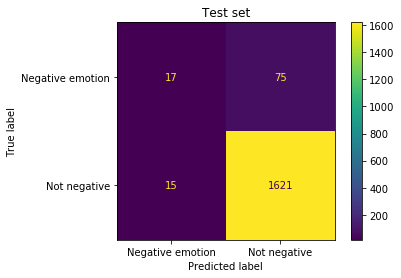

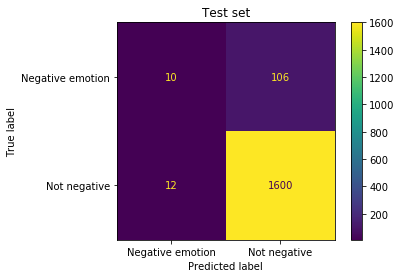

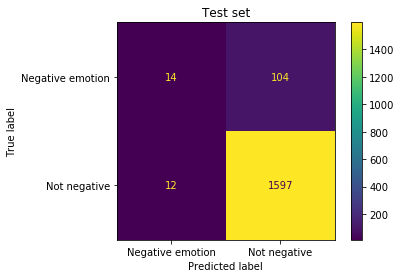

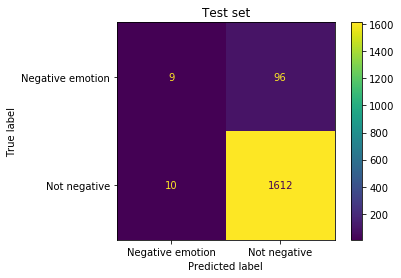

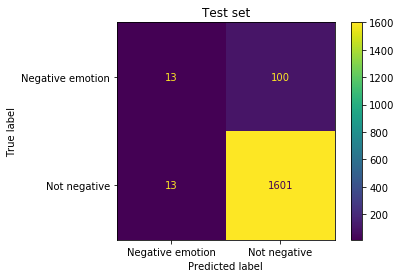

In [26]:
# test baseline model with basic countvectorizer and Multinomial Bayes model

ut.k_fold_validator(X_train, y_train, vectorizer=countvec, classifier=nb_count, cv=5)


In [27]:
# create TF-IDF vectoriser for testing

tfidfvec = TfidfVectorizer()

Vectorizer: TfidfVectorizer()
Classifier: MultinomialNB()
Cross-validation folds: 5


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train mean recall: 0.01 +/- 0.0
Train mean precision: 0.84 +/- 0.1
Train mean F1: 0.02 +/- 0.01
Test mean recall: 0.0 +/- 0.0
Test mean precision: 0.3 +/- 0.45
Test mean F1: 0.01 +/- 0.01


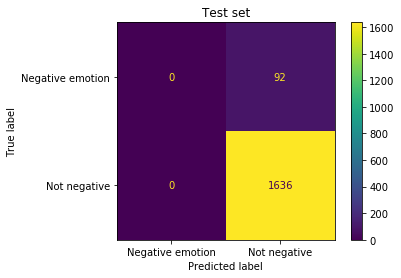

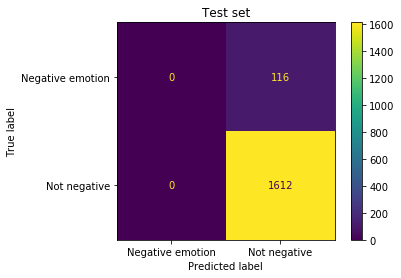

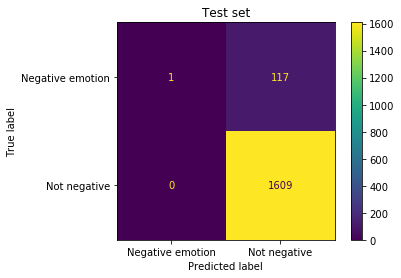

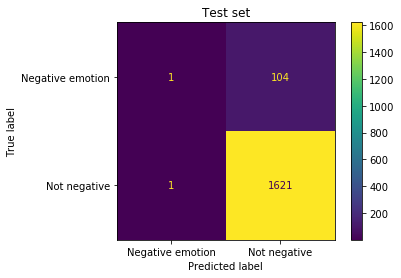

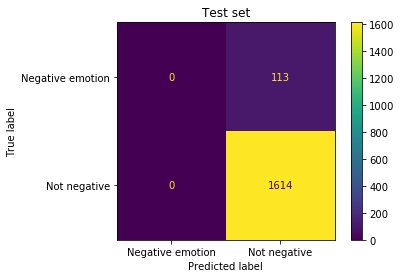

In [28]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=tfidfvec, classifier=nb_count, cv=5)

In [29]:
# create stopwords list for testing

stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
stopwords_list += ['sxsw','mention','rt']

In [30]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [31]:
# create alternative stopwords list for testing
# since tweets are so short, we may be getting good info from punctuation and small words

stopwords_list_2 = ['sxsw', 'mention', 'rt']

In [32]:
cv_stop = CountVectorizer(stop_words=stopwords_list_2)

In [33]:
cv_stop_max = CountVectorizer(stop_words=stopwords_list_2, max_features=3000)

In [34]:
cv_stop_max_ngram = CountVectorizer(stop_words=stopwords_list_2, max_features=3000, ngram_range=(1, 3))

In [35]:
cv_stop_ngram = CountVectorizer(stop_words=stopwords_list_2, ngram_range=(1, 3))

Vectorizer: CountVectorizer(stop_words=['sxsw', 'mention', 'rt'])
Classifier: MultinomialNB()
Cross-validation folds: 5
Train mean recall: 0.42 +/- 0.02
Train mean precision: 0.72 +/- 0.01
Train mean F1: 0.53 +/- 0.01
Test mean recall: 0.13 +/- 0.03
Test mean precision: 0.46 +/- 0.08
Test mean F1: 0.2 +/- 0.04


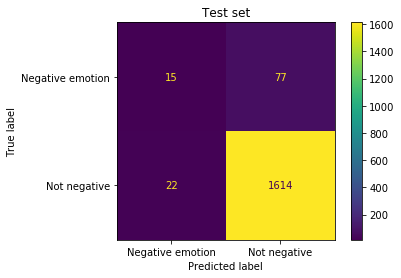

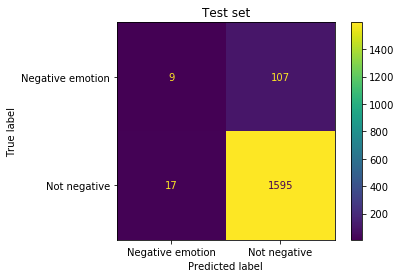

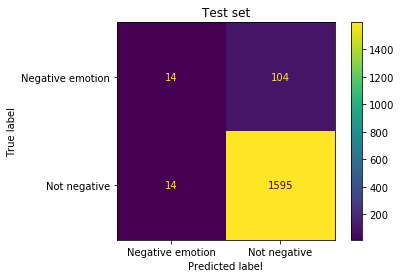

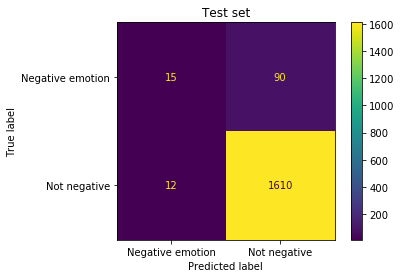

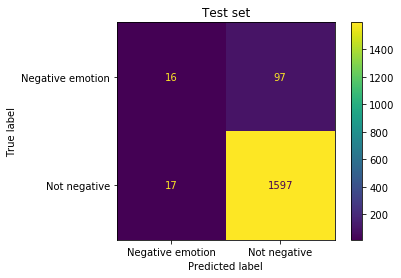

In [36]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop, classifier=nb_count, cv=5)

In [37]:
compnb = ComplementNB()

Vectorizer: CountVectorizer()
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.6 +/- 0.01
Train mean precision: 0.52 +/- 0.01
Train mean F1: 0.56 +/- 0.01
Test mean recall: 0.21 +/- 0.03
Test mean precision: 0.32 +/- 0.05
Test mean F1: 0.25 +/- 0.03


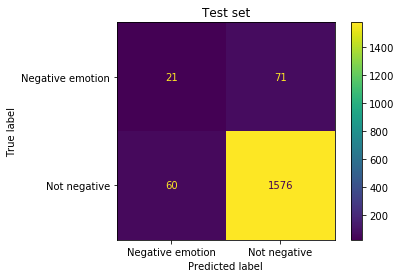

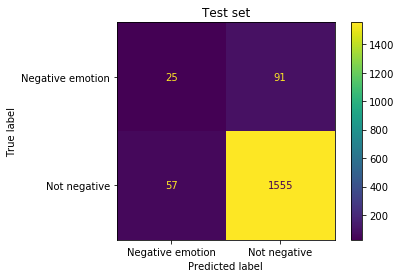

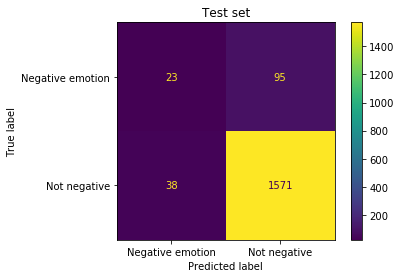

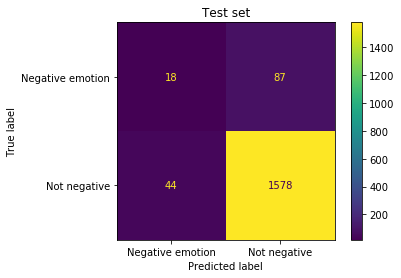

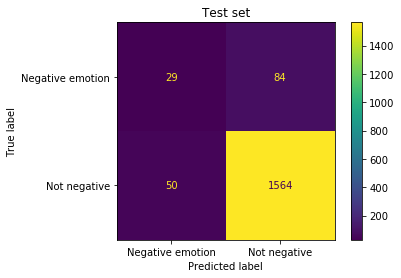

In [38]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=countvec, classifier=compnb, cv=5)

Vectorizer: CountVectorizer(stop_words=['sxsw', 'mention', 'rt'])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.62 +/- 0.02
Train mean precision: 0.49 +/- 0.01
Train mean F1: 0.55 +/- 0.01
Test mean recall: 0.24 +/- 0.04
Test mean precision: 0.31 +/- 0.06
Test mean F1: 0.27 +/- 0.04


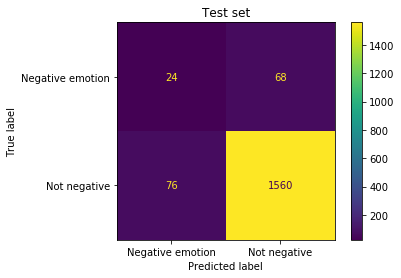

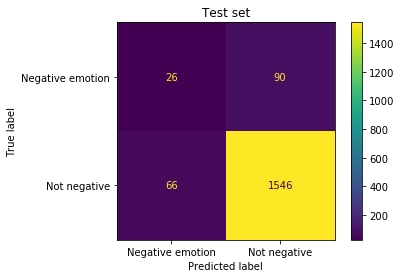

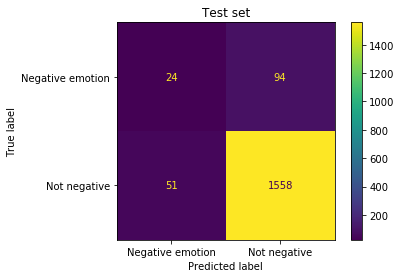

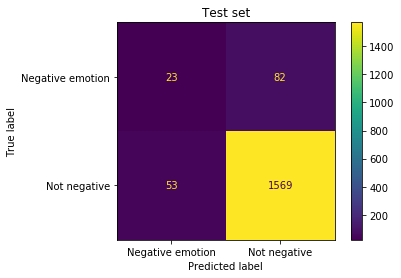

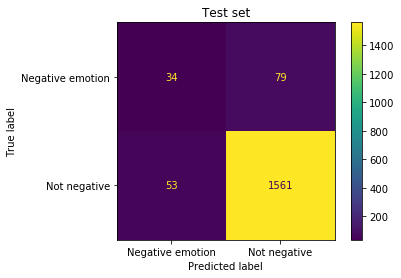

In [39]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop, classifier=compnb, cv=5)

Vectorizer: CountVectorizer(max_features=3000, stop_words=['sxsw', 'mention', 'rt'])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.81 +/- 0.02
Train mean precision: 0.27 +/- 0.01
Train mean F1: 0.41 +/- 0.01
Test mean recall: 0.57 +/- 0.04
Test mean precision: 0.21 +/- 0.02
Test mean F1: 0.31 +/- 0.02


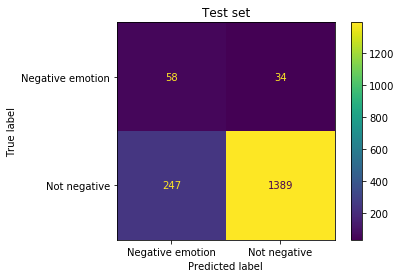

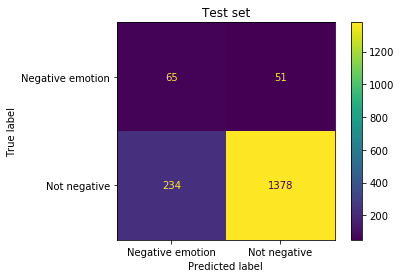

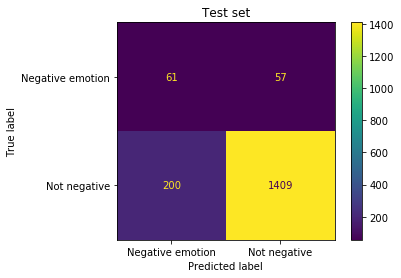

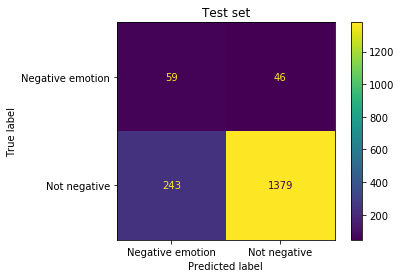

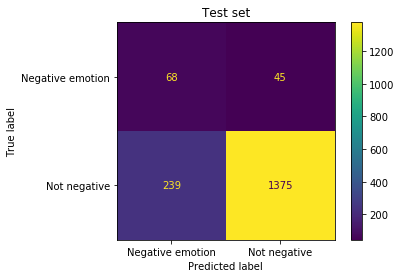

In [40]:
# max features improves recall

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max, classifier=compnb, cv=5)

Vectorizer: CountVectorizer(max_features=3000, ngram_range=(1, 3),
                stop_words=['sxsw', 'mention', 'rt'])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.89 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean F1: 0.32 +/- 0.01
Test mean recall: 0.73 +/- 0.03
Test mean precision: 0.16 +/- 0.02
Test mean F1: 0.26 +/- 0.03


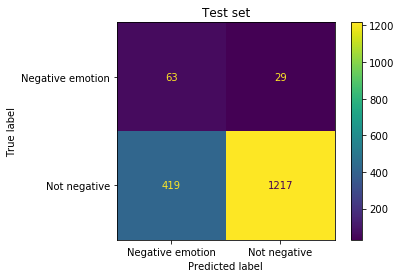

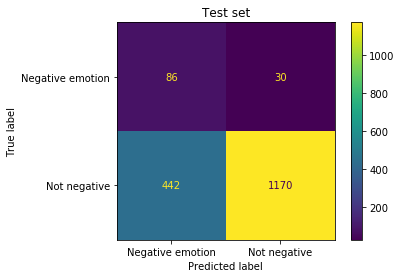

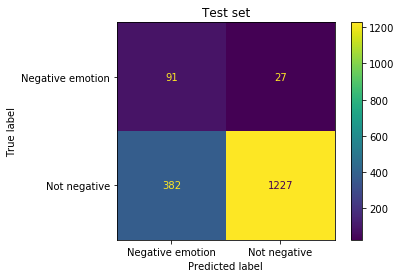

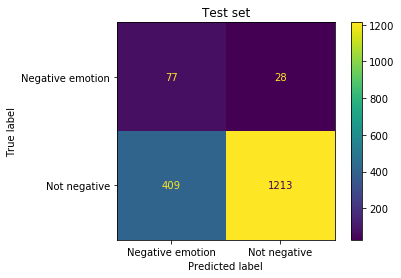

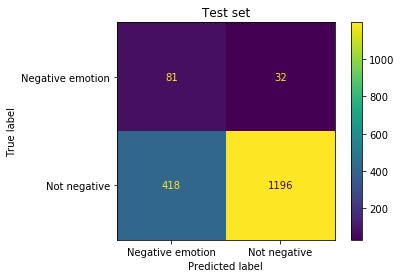

In [41]:
# ngrams improve recall
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max_ngram, classifier=compnb, cv=5)

Vectorizer: CountVectorizer(ngram_range=(1, 3), stop_words=['sxsw', 'mention', 'rt'])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.89 +/- 0.01
Train mean precision: 0.81 +/- 0.01
Train mean F1: 0.85 +/- 0.0
Test mean recall: 0.19 +/- 0.02
Test mean precision: 0.51 +/- 0.07
Test mean F1: 0.27 +/- 0.02


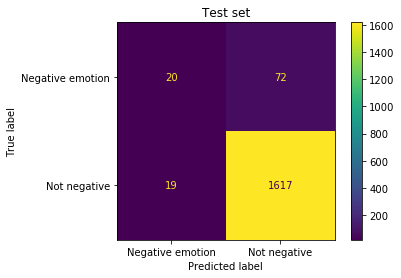

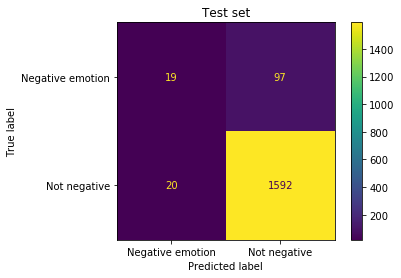

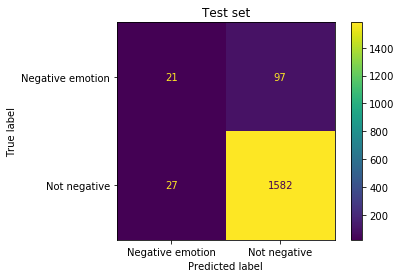

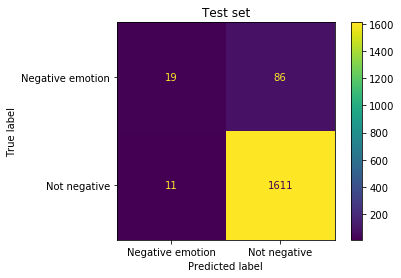

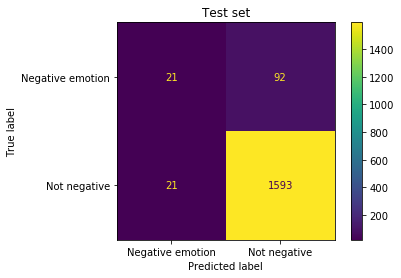

In [42]:
#ngrams don't improve recall without max
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_ngram, classifier=compnb, cv=5)

In [44]:
# max 2k is a little better than 3k and 1k
# ngram range 3 is better than 2 and 4
ut.k_fold_validator(predictor=X, target=y, vectorizer=cv_stop_max_ngram_2, classifier=compnb, cv=5)

NameError: name 'cv_stop_max_ngram_2' is not defined

In [ ]:
# with precision of 15%, you need to read through
100/15
# 7 tweets to find a negative one
# 22% of negative tweets are missed

In [ ]:
# you have to read through 17 tweets to find a negative one
100/6

In [ ]:
# you get through your work 2 or 3 times as fast

In [ ]:
# use glove
# create total vocabulary
X_train_tokens = X_train.map(lambda x: word_tokenize(x))
total_vocabulary = set(word for tweet in X_train_tokens for word in tweet)

In [ ]:
len(total_vocabulary)

In [ ]:
# from Codealong

glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
glove['apple']

In [ ]:
# from Codealong

class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self

    # added this method to work more easily with NLP_model_tester function
    def fit_transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])
    
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
vec_list = [
           ('CountVectorizer', CountVectorizer()),
           ('TfidfVectorizer', TfidfVectorizer()),
           ('W2vVectorizer', W2vVectorizer(glove))]
mod_list = [
#            ('Multinomial Naive Bayes', MultinomialNB()),
#            ('Guassian Naive Bayes', GaussianNB()),
           ('Random Forest', RandomForestClassifier()),
           ('Support Vector Machine', SVC()),
           ('Logistic Regression', LogisticRegression())]

In [ ]:
def NLP_model_tester(X, y, vectorizers, models):
    
    X_tra, X_tst, y_tra, y_tst = train_test_split(X, y, test_size=0.3)
    
    for v in vectorizers:
        for m in models:
            
            X_vec_tra = v[1].fit_transform(X_tra)
            X_vec_tst = v[1].transform(X_tst)
            
            model = m[1]
            model.fit(X_vec_tra, y_tra)
            
            y_pred_tra = m[1].predict(X_vec_tra)
            y_pred_tst = m[1].predict(X_vec_tst)
            
            print(v[0], '/', m[0], 'Train Recall:', round(recall_score(y_tra, y_pred_tra, pos_label='Negative emotion'), 2))
            print(v[0], '/', m[0], 'Train Precision:', round(precision_score(y_tra, y_pred_tra, pos_label='Negative emotion'), 2))

            plot_confusion_matrix(model, X_vec_tra, y_tra)
            plt.title(v[0] + '/' + m[0] + ' Train set')

            print(v[0], '/', m[0], 'Test Recall:', round(recall_score(y_tst, y_pred_tst, pos_label='Negative emotion'), 2))
            print(v[0], '/', m[0], 'Test Precision:', round(precision_score(y_tst, y_pred_tst, pos_label='Negative emotion'), 2))

            plot_confusion_matrix(model, X_vec_tst, y_tst)
            plt.title(v[0] + '/' + m[0] + ' Test set')

            

In [ ]:
NLP_model_tester(X_train, y_train, vec_list, mod_list)


In [ ]:
k_fold_validator(predictor=X_train, target=y_train, vectorizer=CountVectorizer(), classifier=RandomForestClassifier(), cv=5)

In [ ]:
# k-fold cv for logistic regression

kf = KFold(n_splits=5)

train_recall_scores = []
train_precision_scores = []
test_recall_scores = []
test_precision_scores = []

for train_index, test_index in kf.split(X_train):

    X_tr, X_test = X[train_index].astype(str), X[test_index].astype(str)
    y_tr, y_test = y[train_index].astype(str), y[test_index].astype(str)

    vec = CountVectorizer()
    
    X_vec_tr = vec.fit_transform(X_tr)
    X_vec_test = vec.transform(X_test)

    clf = LogisticRegression()
    clf.fit(X_vec_tr, y_tr)

    y_pred_tr = clf.predict(X_vec_tr)
    y_pred_test = clf.predict(X_vec_test)

    train_recall_scores.append(recall_score(y_tr, y_pred_tr, pos_label='Negative emotion'))
    train_precision_scores.append(precision_score(y_tr, y_pred_tr, pos_label='Negative emotion'))
    test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='Negative emotion'))
    test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='Negative emotion'))

    plot_confusion_matrix(clf, X_vec_tr, y_tr)
    plt.title('Train set')

    plot_confusion_matrix(clf, X_vec_test, y_test)
    plt.title('Test set')

print('Vectorizer:', vec)
print('Classifier:', clf)
print('Cross-validation folds:', cv)
print('Train mean recall:', pd.Series(train_recall_scores).mean())
print('Train mean precision:', pd.Series(train_precision_scores).mean())
print('Test mean recall:', pd.Series(test_recall_scores).mean())
print('Test mean precision:', pd.Series(test_precision_scores).mean())



In [ ]:
k_fold_validator(predictor=X_train, 
                 target=y_train, 
                 vectorizer=CountVectorizer(), 
                 classifier=LogisticRegression(), 
                 cv=5)

In [ ]:
# k-fold cv for support vector machine

kf = KFold(n_splits=5)

train_recall_scores = []
train_precision_scores = []
test_recall_scores = []
test_precision_scores = []

for train_index, test_index in kf.split(X_train):

    X_tr, X_test = X[train_index].astype(str), X[test_index].astype(str)
    y_tr, y_test = y[train_index].astype(str), y[test_index].astype(str)

    vec = CountVectorizer()
    
    X_vec_tr = vec.fit_transform(X_tr)
    X_vec_test = vec.transform(X_test)

    clf = SVC()
    clf.fit(X_vec_tr, y_tr)

    y_pred_tr = clf.predict(X_vec_tr)
    y_pred_test = clf.predict(X_vec_test)

    train_recall_scores.append(recall_score(y_tr, y_pred_tr, pos_label='Negative emotion'))
    train_precision_scores.append(precision_score(y_tr, y_pred_tr, pos_label='Negative emotion'))
    test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='Negative emotion'))
    test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='Negative emotion'))

    plot_confusion_matrix(clf, X_vec_tr, y_tr)
    plt.title('Train set')

    plot_confusion_matrix(clf, X_vec_test, y_test)
    plt.title('Test set')

print('Vectorizer:', vec)
print('Classifier:', clf)
print('Cross-validation folds:', cv)
print('Train mean recall:', pd.Series(train_recall_scores).mean())
print('Train mean precision:', pd.Series(train_precision_scores).mean())
print('Test mean recall:', pd.Series(test_recall_scores).mean())
print('Test mean precision:', pd.Series(test_precision_scores).mean())



In [ ]:
k_fold_validator(predictor=X_train, 
                 target=y_train, 
                 vectorizer=CountVectorizer(), 
                 classifier=SVC(), 
                 cv=5)

In [ ]:
# k-fold cv for random forest

kf = KFold(n_splits=5)

train_recall_scores = []
train_precision_scores = []
test_recall_scores = []
test_precision_scores = []

for train_index, test_index in kf.split(X_train):

    X_tr, X_test = X[train_index].astype(str), X[test_index].astype(str)
    y_tr, y_test = y[train_index].astype(str), y[test_index].astype(str)

    vec = CountVectorizer()
    
    X_vec_tr = vec.fit_transform(X_tr)
    X_vec_test = vec.transform(X_test)

    clf = RandomForestClassifier()
    clf.fit(X_vec_tr, y_tr)

    y_pred_tr = clf.predict(X_vec_tr)
    y_pred_test = clf.predict(X_vec_test)

    train_recall_scores.append(recall_score(y_tr, y_pred_tr, pos_label='Negative emotion'))
    train_precision_scores.append(precision_score(y_tr, y_pred_tr, pos_label='Negative emotion'))
    test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='Negative emotion'))
    test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='Negative emotion'))

    plot_confusion_matrix(clf, X_vec_tr, y_tr)
    plt.title('Train set')

    plot_confusion_matrix(clf, X_vec_test, y_test)
    plt.title('Test set')

print('Vectorizer:', vec)
print('Classifier:', clf)
print('Cross-validation folds:', cv)
print('Train mean recall:', pd.Series(train_recall_scores).mean())
print('Train mean precision:', pd.Series(train_precision_scores).mean())
print('Test mean recall:', pd.Series(test_recall_scores).mean())
print('Test mean precision:', pd.Series(test_precision_scores).mean())



In [ ]:
# try a neural net

one_hot_y = pd.get_dummies(y_train).values

In [ ]:
one_hot_y

In [ ]:
tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
list_tokenized_tweets = tokenizer.texts_to_sequences(X_train)
X_t = sequence.pad_sequences(list_tokenized_tweets, maxlen=100)

In [ ]:
nn = Sequential()
embedding_size = 128
nn.add(Embedding(5000, embedding_size))
nn.add(LSTM(25, return_sequences=True))
nn.add(GlobalMaxPool1D())
nn.add(Dropout(0.5))
nn.add(Dense(50, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(2, activation='softmax'))

nn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


nn.summary()

In [ ]:
nn.fit(X_t, one_hot_y, epochs=10, validation_split=0.1)

In [ ]:
# make a df
# pd.DataFrame(columns =)

nn.predict(X_t)